# Difference or similarity between the scored TF in resident and exhausted cells

From scenic we have 2 set of scored TFs. Now to evaluate if they are indeed similar of different, I am going to do some exploratory analysis, then evaluate more robustly which is their similarity.

I will start with:
- plotting their distribution and the top enriched TFs
- Plot the overlap of 10% top eriched TF
- Evaluate scored TF between resident and exhausted NK cells using [Rank Biased Overlap (RBO)](https://dl.acm.org/doi/10.1145/1852102.1852106). This method seems adapt for this comparison because:
    - Can evaluate different sizes of ranked lists
    - It can assign weight to the n top ranks
    - provide a ration (or percentage) of similarity


Prepare environment

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import math
import numpy as np


In [69]:
exh = pd.read_csv("https://raw.githubusercontent.com/VergaJU/BoneMarrow_scRNA-Seq/TransFactor/Transcription_factors/threshold_75/Results/75/mm_exh_regulons_AUC.csv")
res = pd.read_csv("https://raw.githubusercontent.com/VergaJU/BoneMarrow_scRNA-Seq/TransFactor/Transcription_factors/threshold_75/Results/75/mm_res_regulons_AUC.csv")

In [70]:
exh.shape

(2465, 138)

In [71]:
res.shape

(2465, 131)

In [72]:
def fix_names(df):
    genes = df.columns
    genes = [s.replace("_(+)", "") for s in genes]
    df.columns = genes
    return df
exh = fix_names(exh)
res = fix_names(res)

def sort_extract(df):
    TFs = df.iloc[0,:].sort_values(ascending=False).astype(float)
    
    return TFs

exh_TF = sort_extract(exh)
res_TF = sort_extract(res)

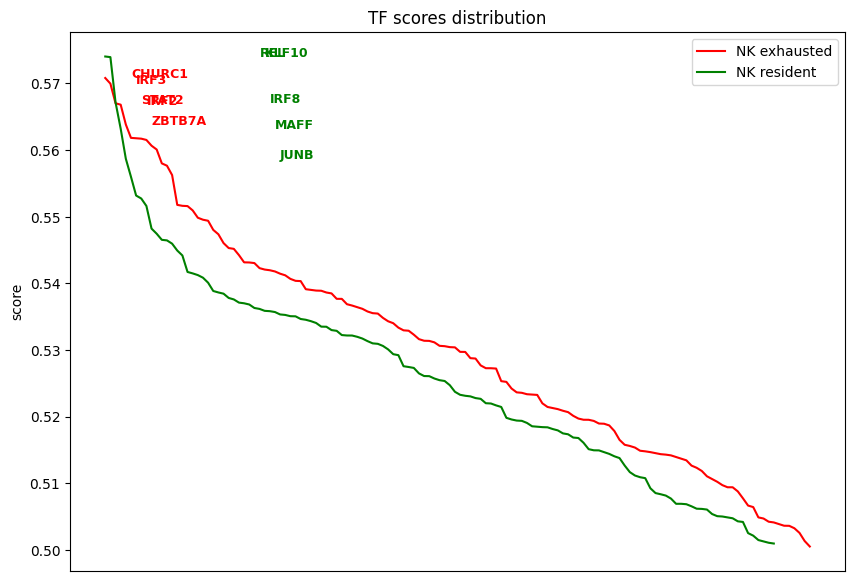

In [73]:
fig = plt.figure(figsize=(10,7))
# add lines for the 2 sets
plt.plot(exh_TF.values, label = "NK exhausted", color = "r")
plt.plot(res_TF.values, label = "NK resident", color = "g")
#get current axes
ax = plt.gca()

## add top 5 TFs for each set
for index in range(5):
    ax.text(index+5, exh_TF[index],s= list(exh_TF.index)[index], size=9, color = "r", weight = 600)

for index in range(5):
    ax.text(index+30, res_TF[index],s= list(res_TF.index)[index], size=9, color = "g", weight = 600)
#hide x-axis
ax.get_xaxis().set_visible(False)
plt.xlabel("TFs")
plt.ylabel("score")
plt.title("TF scores distribution")
plt.legend()
plt.show()

The distribution of (normalized) scores is quite similar, also of the top 5 scored TFs, 4 ae the same for both the conditions, let's check what they and their regulons are about:

In [74]:
print("Top 10 (specificity) TFs for Exhausted cells")
pd.DataFrame(exh_TF.sort_values(ascending=False)[:10])

Top 10 (specificity) TFs for Exhausted cells


,0
CHURC1,0.570800
IRF3,0.569955
STAT2,0.567008
IRF2,0.566800
ZBTB7A,0.563829
USF2,0.561821
IRF7,0.561758
STAT1,0.561702
NFIA,0.561509
IRF9,0.560645


In [75]:
print("Top 10 (specificity) TFs for Resident cells")
pd.DataFrame(res_TF.sort_values(ascending=False)[:10])

Top 10 (specificity) TFs for Resident cells


,0
REL,0.574026
KLF10,0.573933
IRF8,0.567153
MAFF,0.563195
JUNB,0.558689
NFKB1,0.555983
ETV3,0.553170
SP3,0.552722
ZBTB21,0.551607
FOSL2,0.548208


### Phenotypes and Gene Ontology

interactive(children=(Dropdown(description='dataframe', options=('exh', 'res'), value='exh'), Select(descripti…

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

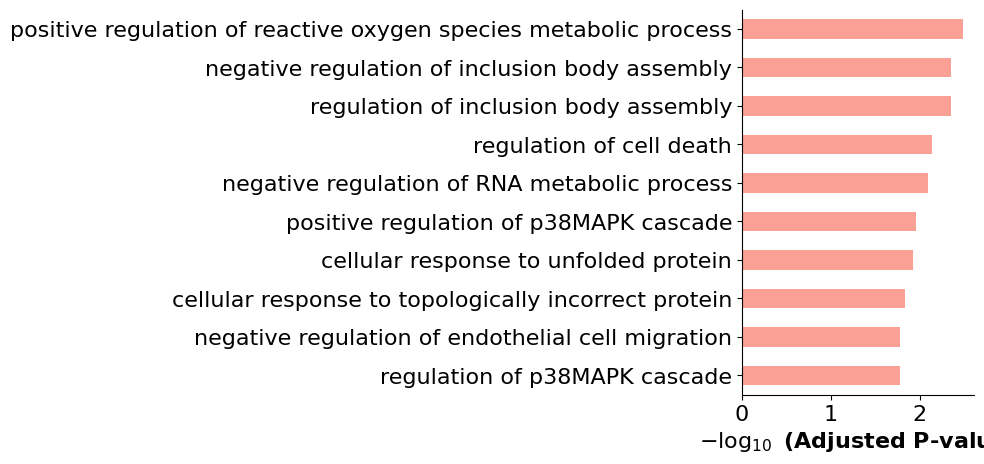

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

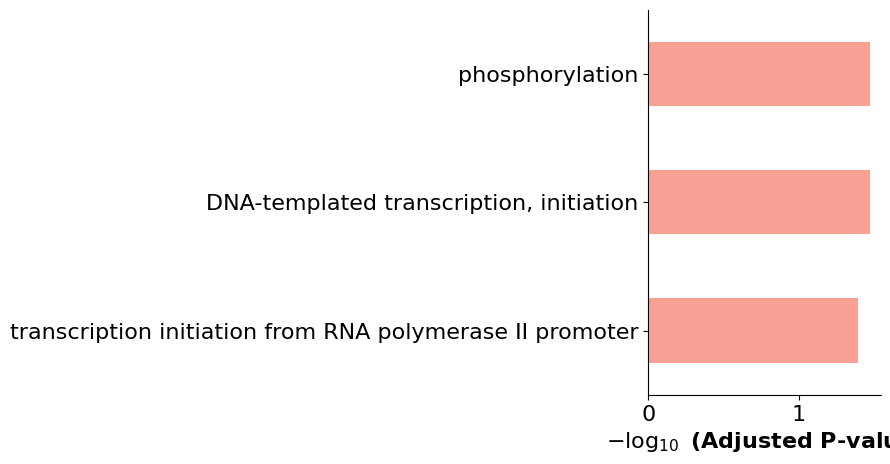

In [83]:
!pip install -q gseapy

from gseapy import Biomart
import gseapy as gp
import ipywidgets as widgets
from IPython.display import display, Image
from ipywidgets import interact_manual

exh_regulons = exh.iloc[1:]
res_regulons = res.iloc[1:]

bm = Biomart()

items = sorted(exh_TF.index.unique().tolist())
tab = ["Gene Ontology", "Phenotype"]

dfs = {"exh": exh_regulons, "res": res_regulons}

w = widgets.Select(options=items)
x = widgets.Select(options=tab)


def get_info(gene):
    query ={'external_gene_name':[gene]}
    results = bm.query(dataset='hsapiens_gene_ensembl',attributes=['external_gene_name','description','phenotype_description'],filters=query)
    return results


def GOs(regulon):
    # Enricr API
    GOs = gp.enrichr(regulon,
                        gene_sets='GO_Biological_Process_2021',
                        outdir=None)

    # trim (go:...)
    GOs.res2d.Term = GOs.res2d.Term.str.split(" \(GO").str[0]

   
    pic = gp.barplot(GOs.res2d,figsize=(3,5), cmap = plt.cm.autumn_r)
    return pic

@interact_manual
def view_info(dataframe=dfs.keys(), analysis=x, TF=w):
    try:
      exh_score = [exh_TF[TF]]
    except KeyError:
      exh_score = ["na"]
      pass
    try:
      res_score = [res_TF[TF]]
    except  KeyError:
      res_score = ["na"]
      pass
    print(f"Transcription factor: {TF}\nScores")
    df = pd.DataFrame({'Exh': exh_score,'Res': res_score})
    #display(df)
    if analysis == "Phenotype":
        gene = list(dfs[dataframe].columns[dfs[dataframe].columns == TF])[0]
        pheno = get_info(gene)
        return display(pheno)
    elif analysis == "Gene Ontology":
        regulon = list(dfs[dataframe][TF].dropna())
        fig = plt.figure(figsize=(5,5))
        try:
          pic = GOs(regulon)
        except ValueError:
          print("No GO terms found")
          pic = Image(url="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExN2M1ZmY1NjcwOTVjMzlmNTA0ZWE1Y2VjZGU3NjhmODcxN2MxNmMxOSZlcD12MV9pbnRlcm5hbF9naWZzX2dpZklkJmN0PWc/3o84sF21zQYacFcl68/giphy-downsized.gif")
          pass
        except KeyError:
          print("The TF you are looking for isn't here")
          pic = Image(url="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExN2M1ZmY1NjcwOTVjMzlmNTA0ZWE1Y2VjZGU3NjhmODcxN2MxNmMxOSZlcD12MV9pbnRlcm5hbF9naWZzX2dpZklkJmN0PWc/3o84sF21zQYacFcl68/giphy-downsized.gif")
          pass

        return display(pic)



## Top 10% enriched TFs:

In [79]:
exh_regulons["CHURC1"]

1         AASDH
2         ABCB1
3         ABCE1
4       ABHD17A
5        ADGRG1
         ...   
2460        NaN
2461        NaN
2462        NaN
2463        NaN
2464        NaN
Name: CHURC1, Length: 2464, dtype: object

In [ ]:
top_exh_TF = exh_TF[exh_TF >= exh_TF.quantile(.9)]
top_res_TF = res_TF[res_TF >= res_TF.quantile(.9)]


In [ ]:
top_exh_TF.shape

In [ ]:
top_res_TF.shape

In [ ]:
venn2([set(list(top_exh_TF.index)), set(list(top_res_TF.index))],set_labels = ('NK Exhausted', 'NK Resident'))
plt.title("Top enriched TFs")
plt.show()

In [ ]:
only_exh = list(set(list(top_exh_TF.index))- set(list(top_res_TF.index)))
only_res = list(set(list(top_res_TF.index))- set(list(top_exh_TF.index)))
intersection = list(set(list(top_exh_TF.index))& set(list(top_res_TF.index)))

print(f"TF only in exhausted cells:\n{only_exh}\nTF only in resident:\n{only_res}\nTF shared:\n{intersection}")

In [ ]:
venn2([set(list(exh_TF.index)), set(list(res_TF.index))],set_labels = ('NK Exhausted', 'NK Resident'))
plt.title("All enriched TFs")
plt.show()

In [ ]:
only_exh = list(set(list(exh_TF.index))- set(list(res_TF.index)))
only_res = list(set(list(res_TF.index))- set(list(exh_TF.index)))
intersection = list(set(list(exh_TF.index))& set(list(res_TF.index)))

print(f"TF only in exhausted cells:\n{only_exh}\nTF only in resident:\n{only_res}\nTF shared:\n{intersection}")

## RBO

I plan to run the analysis in:
- all theranked TFs
- The top 10% enriched TF

Also, to polish the analisis I am going to tune the weight parameter in order to assign the appropriate weight to the top n TFs:

In [ ]:

def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext



def weightage_calculator(p,d):
    """ Takes values of p and d
    ----------
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1.
    d : depth at which the weight has to be calculated
    
    Returns
    -------
    Float of Weightage Wrbo at depth d
    """

    summation_term = 0

    for i in range (1, d): # taking d here will loop upto the value d-1 
        summation_term = summation_term + math.pow(p,i)/i


    Wrbo_1_d = 1 - math.pow(p, d-1) +(((1-p)/p) * d *(np.log(1/(1-p)) - summation_term))

    return Wrbo_1_d

def get_rbo(S,T,w,d):
    weight = 0
    p = 0.001
    while round(weight,2) != w:
        weight = weightage_calculator(p,d)
        p += 0.001
    score = rbo(S,T,p=p)
    return p, weight,score


### All TFs

In [ ]:
exh_list = exh_TF.index.to_list()
res_list = res_TF.index.to_list()
D = min([len(exh_list),len(res_list)])
print(f"lenght lists are:\nExh:{len(exh_list)}\tRes:{len(res_list)}\nD max:{D}")

In [ ]:
print(f"similarity considering ranks but without assigning weights to the top TFs:\n{round(rbo(exh_list,res_list,p=1),2)}")

Tuning the weight of the first 10 TFs:

In [ ]:
d=10
p, weight, score = get_rbo(exh_list, res_list, 0.7,d)
 
print(f"value of P to assign 70% of the weight to the first 10 TFs id:\nweight {round(weight,2)}\np: {round(p,3)}")
print(f"Similarity of all the enriched TFs assigning 70% of the score to the top 10:\n{round(score,2)}")

In [ ]:
p, weight, score = get_rbo(exh_list, res_list, 0.9,d)

print(f"value of P to assign 90% of the weight to the first 10 TFs id:\nweight {round(weight,2)}\np: {round(p,3)}")
print(f"Similarity of all the enriched TFs assigning 90% of the score to the top 10:\n{round(score,2)}")

Tuning the weight of the first 10% genes:

In [ ]:
d = int((D/100)*10)

In [ ]:
p, weight, score = get_rbo(exh_list, res_list, 0.9,d)
print(f"value of P to assign 90% of the weight to the first 10% TFs id:\nweight {round(weight,2)}\np: {round(p,3)}")
print(f"Similarity of all the enriched TFs assigning 90% of the score to the top 10:\n{round(score,2)}")

In [ ]:
p, weight, score = get_rbo(exh_list, res_list, 0.7,d)

print(f"value of P to assign 70% of the weight to the first 10% TFs id:\nweight {round(weight,2)}\np: {round(p,3)}")
print(f"Similarity of all the enriched TFs assigning 70% of the score to the top 10:\n{round(score,2)}")

From the results observing all the TFs, we can draw the conclusion that giving most of the importance to the top 10 TFs, the similarity is quite high (0.73). Reducing the weight of the first TFs, or considering the first 10%, the similarity score get significantly reduced. Considering the cell groups are almost identical, I would expect a similari behaviour. Now focus on the top 10% eriched TFs:

### Top 10%

In [ ]:
exh_list = exh_TF[exh_TF >= exh_TF.quantile(0.9)].index.to_list()
res_list = res_TF[res_TF >= res_TF.quantile(0.9)].index.to_list()
D = min([len(exh_list),len(res_list)])
print(f"lenght lists are:\nExh:{len(exh_list)}\tRes:{len(res_list)}\nD max:{D}")

Tuning the weight for the first 25% TFs:

In [ ]:
d = int((D/100)*25)

In [ ]:
p, weight, score = get_rbo(exh_list, res_list, 0.9,6)
 
print(f"value of P to assign 90% of the weight to the first 25% TFs id:\nweight {round(weight,2)}\np: {round(p,3)}")
print(f"Similarity of all the enriched TFs assigning 90% of the score to the top 25%:\n{round(score,2)}")

In [ ]:
p, weight, score = get_rbo(exh_list, res_list, 0.7,6)
 
print(f"value of P to assign 70% of the weight to the first 25% TFs id:\nweight {round(weight,2)}\np: {round(p,3)}")
print(f"Similarity of all the enriched TFs assigning 70% of the score to the top 25%:\n{round(score,2)}")